# Vorticity streamfunction formulation

The incompressible Navier-Stokes momentum equation is:

$$\frac{\partial{\textbf{u}}}{\partial t}+\textbf{u} \cdot\nabla\textbf{u} = -\frac{1}{\rho}\nabla p+\nu\nabla^2\textbf{u}\quad$$

We can take the curl of the momentum equation, noting that the curl $\nabla\times$ of the 2D velocity vector $\bf u$ results in vorticity $\vec{\omega} = \omega\hat{k}$. Noting also that the curl of a gradient is zero ($\nabla\times\nabla = 0$):

$$\frac{\partial\omega}{\partial t}+\textbf{u}\cdot\nabla\omega=\nu\nabla^2\omega$$

The incompressible continuity equation is $\nabla\cdot\textbf u = 0$. For this to hold true, we can define the components of the velocity vector in terms of the spatial derivatives of a potential function $\psi$:

$$u =\frac{\partial\psi}{\partial y}\qquad v=-\frac{\partial\psi}{\partial x}\quad$$

Inserting this into the definition of vorticity, we find that vorticity is:

$$\omega=\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y}=-\frac{\partial\psi^2}{\partial x^2}-\frac{\partial\psi^2}{\partial y^2}$$

This is a Poisson equation for the streamfunction:

$$\nabla^2\psi=-\omega\quad$$

This is now analagous to the Navier-Stokes equations that consist of the momentum and Poisson pressure equations. Now, it is the vorticity transport and Poisson streamfunction equations. This is known as the _vorticity-streamfunction_ formulation of the Navier-Stokes equations.

## Discretization

If we maintain the discretization general by not making the assumpiton that $\Delta x = \Delta y$, we get:

$$\omega^{n+1}_{ij}=\omega^n_{ij}-\frac{\Delta t}{4 \Delta x \Delta y}\left[
\left(\psi^n_{i,j+1}-\psi^n_{i,j-1}\right)\left(\omega^n_{i+1,j}-\omega^n_{i-1,j}\right)+
\left(\psi^n_{i-1,j}-\psi^n_{i+1,j}\right)\left(\omega^n_{i,j+1}-\omega^n_{i,j-1}\right)\right]+
\frac{\nu \Delta t}{\Delta x^2 \Delta y^2} \left[\left(\omega^n_{i+1,j}-2\omega_{ij}+\omega^n_{i,j+1})\Delta x^2 +(\omega^n_{i-1,j}-2\omega_{ij}+\omega^n_{i,j-1}\right)\Delta y^2\right]$$

The Poisson streamfunction can be discretized as:

$$\frac{\psi^{n+1}_{i+1,j}-2\psi^{n+1}_{ij}+\psi^{n+1}_{i-1,j}}{\Delta x^2_1}+\frac{\psi^{n+1}_{i,j+1}-2\psi^{n+1}_{ij}+\psi^{n+1}_{i,j-1}}{\Delta x^2_2}=-\omega^{n+1}_{ij}$$

## Boundary conditions

The no-slip condition $\textbf{u} = 0$ on the boundary gives $\frac{\partial\psi}{\partial x}=\frac{\partial\psi}{\partial y}=$ constant on the boundaries.

Consider a vertical wall, where both $u$ and $v$ are 0. In the vertical direction there is no rate of change of velocity, and therefore the Poisson equation on the vertical wall reduces to:

$$\omega_{wall} = \frac{\partial v}{\partial x} = -\frac{\partial^2\psi}{\partial x^2}$$

Similarly, for horizontal boundaries, the wall-condition for vorticity is:

$$\omega_{wall} = \frac{\partial u}{\partial y} = -\frac{\partial^2\psi}{\partial y^2}$$

Solving for the wall vorticity is tricky. For the Poisson pressure equation, we can take a centered difference for the pressure and perform all computations one node away from the wall. Here, for the vorticity, we do not have that luxury. To solve this, we can take a Taylor expansion for the stream function just at the wall. Take a rigid boundary at $y=L$ moving with velocity $Uwall = \frac{\partial\psi}{\partial y}$ in a horizontal direction. If the wall is point $j=n$:

$$\psi_{i,n-1} = \psi_{i,n} - \frac{\partial \psi_{i,n}}{\partial y}\Delta y + \frac{\partial^2 \psi_{i,n}}{\partial y^2}\frac{\Delta y^2}{2} + O^3$$

which leads to:

$$\omega_{wall} = 2\left(\psi_{i,n} - \psi_{i,n-1}\right)/\Delta y^2 - 2U_{wall}/\Delta y$$

where $n$ is the wall, and $n-1$ is one node away from the wall. Similar results are obtained for vertical walls, just with the indices switched. Notice that in the Taylor expansion, negatives on the $U_{wall}$ term appear whenever the indices are $n, n-1$, but the term will be postive whenever the indices are $n, n+1$. In our cavity flow case, it will be negative, since the lid indices will be $n, n-1$.

## Poisson stream function

If we desire to obtain a solution for the stream function one time step ahead, we follow the same procedure as the Poisson pressure equation and solve for $\psi^{n+1}_{ij}$ in the Poisson stream function equation. Maintaining the generality of having different spacings in the x and y directions, we obtain:

$$\psi^{n+1}_{ij} = \frac{\Delta x^2 \Delta y^2}{2\left(\Delta x^2 + \Delta y^2\right)}\omega^n_{ij} + \frac{1}{2\left(\Delta x^2 + \Delta y^2\right)}\left[\left(\psi^n_{i+1,j}+\psi^n_{i-1,j}\right)\Delta y^2 + \left(\psi_{i,j+1}+\psi_{i,j-1}\right)\Delta x^2\right]$$

which is a Jacobian approach to solving the Poisson equation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
def rel_error(old, new):
    idx = np.argmax(np.abs(old-new))
    max_diff = np.max(np.abs(old-new))
    small_num = 1e-6
    err= max_diff/(np.abs(old.reshape(-1)[idx])+small_num)
    return err

def plot3d(X, Y, data):
    fig = plt.figure(figsize=(11,7))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, data, cmap=cm.viridis)
    
def solvePoissonJacobi(psi, om, dx, dy):
    ''' Solve the Poisson stream function equation via Jacobi'''
    i = 0
    err_val = 1e-4
    max_iter = 500
    while True:
        i += 1
        pn = np.copy(psi)
        # Boundary conditions, can choose any constant for stream function at wall
        pn[0,:] = 0
        pn[-1,:] = 0
        pn[:,0] = 0
        pn[:,-1] = 0
        
        psi[1:-1,1:-1] = (dx**2*dy**2/(2*(dx**2+dy**2))*om[1:-1,1:-1]
                         + 1/(2*(dx**2+dy**2))*((pn[1:-1,2:]+pn[1:-1,:-2])*dy**2
                                            + (pn[2:,1:-1]+pn[:-2,1:-1])*dx**2))
        err = rel_error(pn, psi)
#         if i%10 == 0:
#             print(f'Iteration: {i}')
        if err < err_val:
            break
        if i > max_iter:
            break
    return psi

In [4]:
# Test out the Poisson function computations
nx = 41
ny = 41
Lx = 2.
Ly = 2.
dx = Lx/(nx-1)
dy = Ly/(ny-1)
p = np.zeros((ny, nx))
w = np.zeros((ny, nx))
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)
# Set up the initial values
w[ny//2,nx//2]=1/dx**2
w[ny//3,nx//3]=-2/dx**2
w[int(2*ny/3),int(2*nx/3)]=-2/dx**2
p1 = solvePoissonJacobi(p, w, dx, dy)

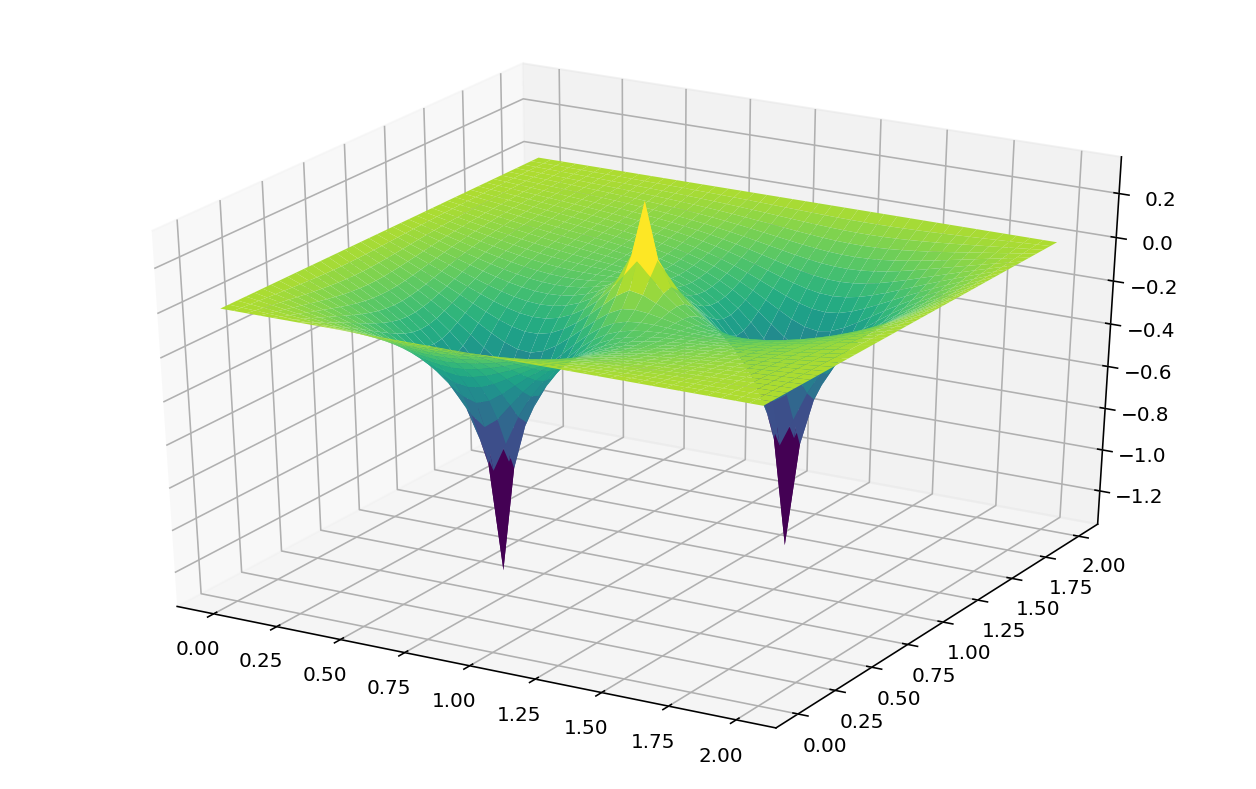

In [5]:
plot3d(X, Y, p1)

Given three initial point sources of vorticity, the above graph shows the distribution of the stream function in the domain, once the Poisson equation for the stream function reached the desired level of congergence. Decreasing the convergence error may cause the Poisson loop to reach the maximum iterations.

In [6]:
maxstep=500            #number of steps
ps = np.zeros((nx,ny)) #Psi
om = np.zeros((nx,ny)) #omega
Uwall=3.0              #velocity of the wall
nu=0.1                 #kinematic viscosity
dt=0.001               #delta t

CFL1= nu*dt/dx**2 + nu*dt/dy**2  # should be smaller than 1/2
print(f'CFL1={CFL1:.2f}')
CFL2=Uwall*dt/dx                 # should be smaller than 1/2
print(f'CFL2={CFL2:.2f}')
Re=Lx*Uwall/nu
print(f'Re={Re:.2f}')            # Reynold's number

## Implement vorticity transport ##
for n in range(maxstep):
    omn = np.copy(om)
    p = solvePoissonJacobi(ps,omn,dx,dy)
    om[1:-1,1:-1] = (omn[1:-1,1:-1] - dt/(4*dx*dy)
                    * ((p[2:,1:-1]-p[:-2,1:-1])*(omn[1:-1,2:]-omn[1:-1,:-2])
                      + (p[1:-1,2:]-p[1:-1,:-2])*(omn[2:,1:-1]-omn[:-2,1:-1]))
                    + nu*dt/(dx**2*dy**2)
                    * ((omn[1:-1,2:]-2*omn[1:-1,1:-1]+omn[1:-1,:-2])*dx**2
                      + (omn[2:,1:-1]-2*omn[1:-1,1:-1]+omn[:-2,1:-1])*dy**2))
    # Boundary conditions
    om[-1,:] = 2*(p[-1,:]-p[-2,:])/dy**2 - 2*Uwall/dy  # y = Ly
    om[0,:] = 2*(p[0,:]-p[1,:])/dy**2                  # y = 0
    om[:,0] = 2*(p[:,0]-p[:,1])/dx**2                  # x = 0
    om[:,-1] = 2*(p[:,-1]-p[:,-2])/dx**2               # x = Lx
# Calculate velocities from streamfunction
# u = dp/dy, v = -dp/dx
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
u[1:-1,1:-1] = (p[2:,1:-1]-p[:-2,1:-1])/(2*dy)
v[1:-1,1:-1] = -(p[1:-1,2:]-p[1:-1,:-2])/(2*dx)

CFL1=0.08
CFL2=0.06
Re=60.00


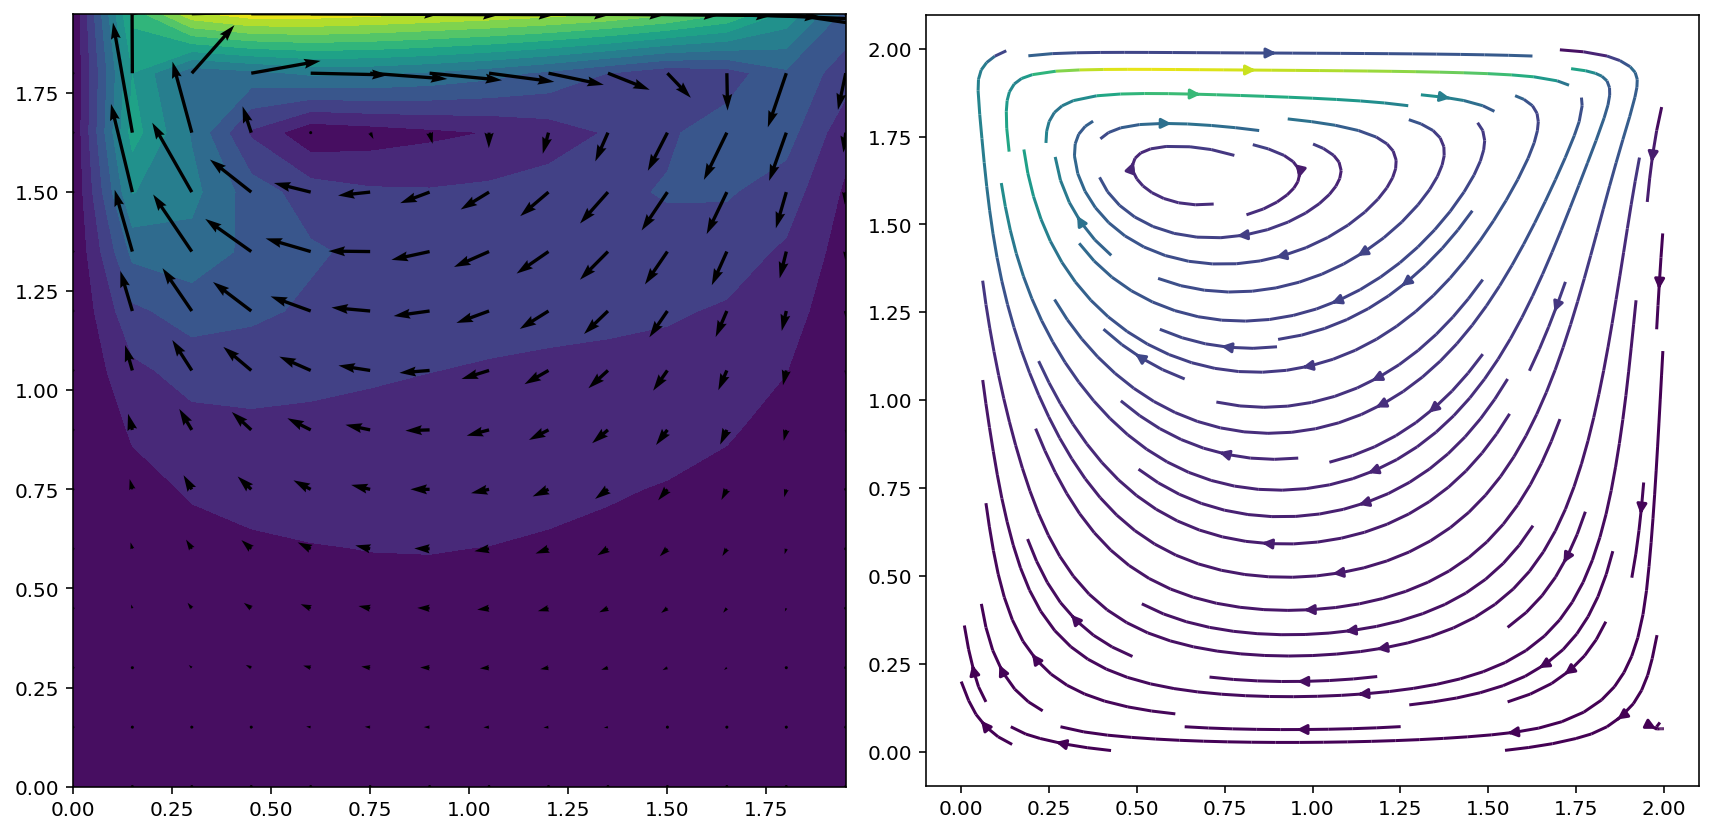

In [7]:
mag = np.sqrt(u**2+v**2)
fig = plt.figure(figsize=(12,12)) 
ax1 = fig.add_subplot(121,aspect='equal') #two figures side-by-side
ax2 = fig.add_subplot(122,aspect='equal')
#ax1.imshow(mag, interpolation='nearest',extent=[0,Lx,0,Ly],origin='lower')#color showing abs velocity
# uabs=np.sqrt(u1**2+u2**2)
#ax2.streamplot(X[1:-1,1:-1],Y[1:-1,1:-1],u1.T,u2.T,color=uabs.T, linewidth=2, cmap=plt.cm.autumn)#streamline plot
surf = ax1.contourf(X[::3,::3], Y[::3,::3], mag[::3,::3], levels=15)
quiv = ax1.quiver(X[::3,::3], Y[::3,::3], u[::3,::3], v[::3,::3])
ax2.streamplot(X, Y, u, v, color=mag, cmap=cm.viridis)
plt.tight_layout()